# **NLP Fake News Classifier Model Development Notebook**

This notebook will serve as an environment to develop the fake news classifier for our web application. For future development phases, I hope this notebook will serve you well in terms of how the model is made, and its overall documentation in your development.

In this notebook, we aim to achieve the following:

- Load the dataset and prepare the Tagalog Fake News [dataset](https://huggingface.co/datasets/jcblaise/fake_news_filipino) for preprocessing
- Preprocess the dataset for training.
  - Use the following tools at your disposal, since Tagalog is a low-resource language:
    - [stopwords-tl](https://github.com/stopwords-iso/stopwords-tl)
    - [tagalog-stemmer](https://github.com/andrianllmm/tagalog-stemmer)
    - [calamanCy](https://github.com/ljvmiranda921/calamanCy)
- Train the following machine learning models:
  - Logistic Regression
  - Multinomial Naive Bayes
  - Support Vector Machine
  - Random Forests
- Evaluate the performance of each machine learning model
- Use 3-5 trained models for the ensemble approach
- Perform inference on sample data with [LIME](https://github.com/marcotcr/lime.git)

## **OBJECTIVE 1** 

Load the dataset and prepare the Tagalog Fake News [dataset](https://huggingface.co/datasets/jcblaise/fake_news_filipino) for preprocessing

In [1]:
from datasets import load_dataset
dataset_dict = load_dataset("jcblaise/fake_news_filipino", trust_remote_code=True)

dataset = dataset_dict['train']

labels = []
articles = []
for data in dataset:
    labels.append(data['label'])
    articles.append(data['article'])

c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
len(labels), len(articles)

(3206, 3206)

Now that our dataset is separated into lists, we can transfer them to `pandas`' dataframe object for ease of use.

In [3]:
import pandas as pd
df = pd.DataFrame({
    "articles": articles,
    "labels": labels
})
df.head()

,articles,labels
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",0
1,Kilala rin ang singer sa pagkumpas ng kanyang ...,0
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",0
3,"Kasama sa programa ang pananalangin, bulaklak ...",0
4,Linisin ang Friendship Department dahil dadala...,0


This is actually enough. But before we proceed, we need to ensure data integrity before we send it to preprocessing.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206 entries, 0 to 3205
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   articles  3206 non-null   object
 1   labels    3206 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.2+ KB


So far, we have correct data types, complete number of data, and is of non-null.

Let's see the distribution of word counts to see if there are outliers.

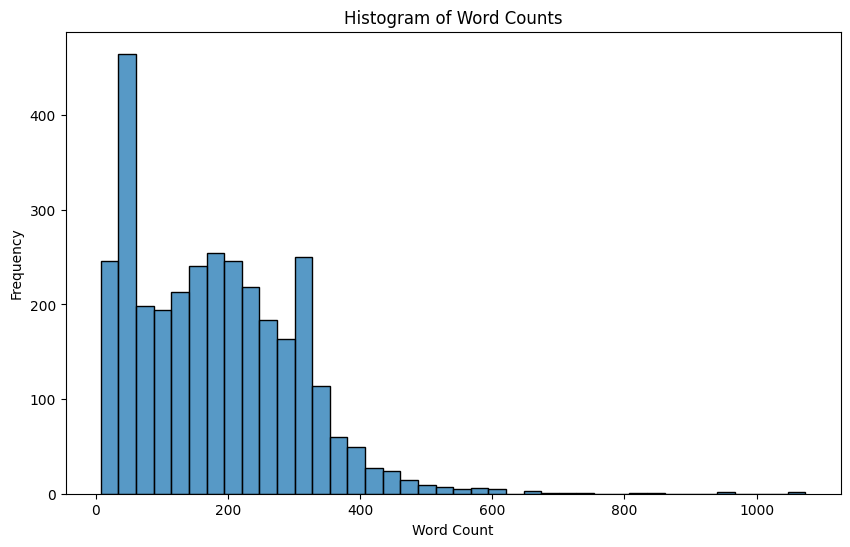

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

word_counts = [len(text.split()) for text in articles]

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=40, kde=False)
plt.title('Histogram of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

Notice that we have an unusual word count (over 400!) of articles between 0 and 200. Let's plot the word count for each class and see the word count distribution for each class.

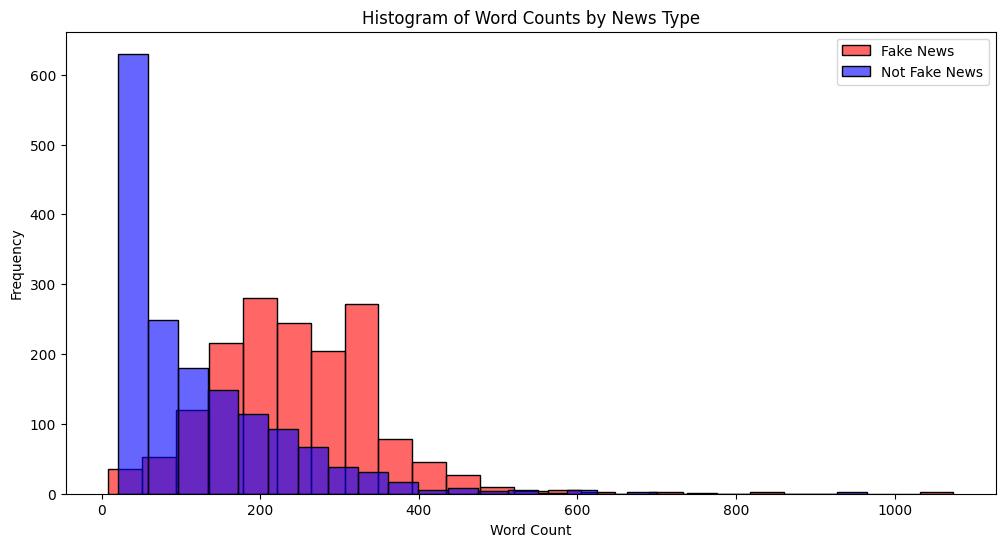

In [6]:
df['word_count'] = df['articles'].apply(lambda x: len(x.split()))

# Plotting the histograms
plt.figure(figsize=(12, 6))
sns.histplot(df[df['labels'] == 1]['word_count'], bins=25, kde=False, color='red', label='Fake News', alpha=0.6)
sns.histplot(df[df['labels'] == 0]['word_count'], bins=25, kde=False, color='blue', label='Not Fake News', alpha=0.6)

plt.title('Histogram of Word Counts by News Type')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()

plt.show()

Interesting. It seems that most articles that are not fake news have plenty of articles that are over 400 words, while, surprisingly, the fake news class have some pretty well distributed word count.

We need to take this into account when training, as it may not be able to generalize well, or perhaps even overfit in the not fake news class due to high word count.

## **OBJECTIVE 2**
- Preprocess the dataset for training.
  - Use the following tools at your disposal, since Tagalog is a low-resource language:
    - [stopwords-tl](https://github.com/stopwords-iso/stopwords-tl)
    - [tagalog-stemmer](https://github.com/andrianllmm/tagalog-stemmer)
    - or use [calamanCy](https://github.com/ljvmiranda921/calamanCy) for lemmatization

Before we create a method to handle all preprocessing steps, let's go through the preprocessing steps one by one to understand how will our preprocessing pipeline will work. Remember, Tagalog is a low-resource language, hence we need to understand how we can integrate multiple open-source tools to achieve our goal.

In [7]:
sample_text = dataset[0]['article']
sample_text

'Ayon sa TheWrap.com, naghain ng kaso si Krupa, 35, noong Huwebes dahil nakaranas umano siya ng emotional distress bunga ng mga malisyosong pahayag ni Glanville, hindi lamang tungkol sa maselang bahagi ng kanyang katawan kundi pati na rin sa kanyang buhay pag-ibig. Noong Nobyembre 2013, napanood si Brandi sa Watch What Happens Live at sinabing kinausap umano ito ng dating karelasyon ni Joanna. Si Mohamed Hadid, na noon ay kasal sa cast member ng Real Housewives of Beverly Hills na si Yolanda Foster habang nasa relasyon, ang nagsabing ang kanyang "p--sy smelled." (Classy pa rin naman ang pagkakabanggit dito ni Brandi.) Noong Disyembre, gumawa ng mga panibagong komento si Glanville, 42, sa kanyang pagharap sa YouTube at sinabing, "You can\'t help the odor situation." Makalipas ang ilang linggo, nagpadala ng sulat ang mga abogado ni Krupa kay Brandi tungkol sa kanilang planong pagsampa ng kaso. Nakalakip sa sulat ng abogado ni Joanna na, "You knew your statements were false and that such 

In [8]:
import string
from nltk.tokenize import word_tokenize 

# convert text to lowercase
lower_text = sample_text.lower()

# remove punctuation
no_punc = lower_text.translate(str.maketrans('', '', string.punctuation))

# tokenize
tokenized = word_tokenize(no_punc)

In [9]:
tokenized, len(tokenized), type(tokenized)

(['ayon',
  'sa',
  'thewrapcom',
  'naghain',
  'ng',
  'kaso',
  'si',
  'krupa',
  '35',
  'noong',
  'huwebes',
  'dahil',
  'nakaranas',
  'umano',
  'siya',
  'ng',
  'emotional',
  'distress',
  'bunga',
  'ng',
  'mga',
  'malisyosong',
  'pahayag',
  'ni',
  'glanville',
  'hindi',
  'lamang',
  'tungkol',
  'sa',
  'maselang',
  'bahagi',
  'ng',
  'kanyang',
  'katawan',
  'kundi',
  'pati',
  'na',
  'rin',
  'sa',
  'kanyang',
  'buhay',
  'pagibig',
  'noong',
  'nobyembre',
  '2013',
  'napanood',
  'si',
  'brandi',
  'sa',
  'watch',
  'what',
  'happens',
  'live',
  'at',
  'sinabing',
  'kinausap',
  'umano',
  'ito',
  'ng',
  'dating',
  'karelasyon',
  'ni',
  'joanna',
  'si',
  'mohamed',
  'hadid',
  'na',
  'noon',
  'ay',
  'kasal',
  'sa',
  'cast',
  'member',
  'ng',
  'real',
  'housewives',
  'of',
  'beverly',
  'hills',
  'na',
  'si',
  'yolanda',
  'foster',
  'habang',
  'nasa',
  'relasyon',
  'ang',
  'nagsabing',
  'ang',
  'kanyang',
  'psy',
 

After standard preprocessing steps, we have a list of words that we can use. Beyond this point, we will be using custom tools for advanced preprocessing. 

In [10]:
# acquiring the stopwords
import wget
url = 'https://raw.githubusercontent.com/stopwords-iso/stopwords-tl/master/stopwords-tl.txt'

# Download the stopwords file
wget.download(url, './stopwords-tl.txt')

'./stopwords-tl (1).txt'

In [11]:
tl_stopwords = []
f = open("./stopwords-tl.txt", "r")
for x in f:
    x = x.rstrip('\n')
    tl_stopwords.append(x)
f.close()
    
tl_stopwords, len(tl_stopwords)

(['akin',
  'aking',
  'ako',
  'alin',
  'am',
  'amin',
  'aming',
  'ang',
  'ano',
  'anumang',
  'apat',
  'at',
  'atin',
  'ating',
  'ay',
  'bababa',
  'bago',
  'bakit',
  'bawat',
  'bilang',
  'dahil',
  'dalawa',
  'dapat',
  'din',
  'dito',
  'doon',
  'gagawin',
  'gayunman',
  'ginagawa',
  'ginawa',
  'ginawang',
  'gumawa',
  'gusto',
  'habang',
  'hanggang',
  'hindi',
  'huwag',
  'iba',
  'ibaba',
  'ibabaw',
  'ibig',
  'ikaw',
  'ilagay',
  'ilalim',
  'ilan',
  'inyong',
  'isa',
  'isang',
  'itaas',
  'ito',
  'iyo',
  'iyon',
  'iyong',
  'ka',
  'kahit',
  'kailangan',
  'kailanman',
  'kami',
  'kanila',
  'kanilang',
  'kanino',
  'kanya',
  'kanyang',
  'kapag',
  'kapwa',
  'karamihan',
  'katiyakan',
  'katulad',
  'kaya',
  'kaysa',
  'ko',
  'kong',
  'kulang',
  'kumuha',
  'kung',
  'laban',
  'lahat',
  'lamang',
  'likod',
  'lima',
  'maaari',
  'maaaring',
  'maging',
  'mahusay',
  'makita',
  'marami',
  'marapat',
  'masyado',
  'may',
  'm

We have 257 words for our sample text. Let's see how many words will be left after stopword removal.

In [12]:
tl_no_stopword = []
for token in tokenized:
    if token not in tl_stopwords:
        tl_no_stopword.append(token)
        
tl_no_stopword, len(tl_no_stopword)

(['ayon',
  'thewrapcom',
  'naghain',
  'kaso',
  'si',
  'krupa',
  '35',
  'noong',
  'huwebes',
  'nakaranas',
  'umano',
  'emotional',
  'distress',
  'bunga',
  'malisyosong',
  'pahayag',
  'glanville',
  'maselang',
  'bahagi',
  'katawan',
  'kundi',
  'pati',
  'rin',
  'buhay',
  'pagibig',
  'noong',
  'nobyembre',
  '2013',
  'napanood',
  'si',
  'brandi',
  'watch',
  'what',
  'happens',
  'live',
  'sinabing',
  'kinausap',
  'umano',
  'dating',
  'karelasyon',
  'joanna',
  'si',
  'mohamed',
  'hadid',
  'kasal',
  'cast',
  'member',
  'real',
  'housewives',
  'of',
  'beverly',
  'hills',
  'si',
  'yolanda',
  'foster',
  'nasa',
  'relasyon',
  'nagsabing',
  'psy',
  'smelled',
  'classy',
  'rin',
  'naman',
  'pagkakabanggit',
  'brandi',
  'noong',
  'disyembre',
  'panibagong',
  'komento',
  'si',
  'glanville',
  '42',
  'pagharap',
  'youtube',
  'sinabing',
  'you',
  'cant',
  'help',
  'the',
  'odor',
  'situation',
  'makalipas',
  'ilang',
  'lin

From 257 words to 192 words after stopword removal. Let us take it up a notch by applying lemmatization. We'll use `calamanCy` for this.

In [13]:
import calamancy
nlp = calamancy.load("tl_calamancy_md-0.2.0")

c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\spacy\util.py:918: UserWarning: [W094] Model 'tl_calamancy_md' (0.2.0) specifies an under-constrained spaCy version requirement: >=3.8.3. This can lead to compatibility problems with older versions, or as new spaCy versions are released, because the model may say it's compatible when it's not. Consider changing the "spacy_version" in your meta.json to a version range, with a lower and upper pin. For example: >=3.8.5,<3.9.0
  warnings.warn(warn_msg)
c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\admin\Desktop\Classes\2nd sem\NLP\NLP Finals\backend\.venv\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._regist

In [15]:
res = ' '.join(tl_no_stopword)

tokens = []

# Example usage
doc = nlp(res)
for token in doc:
    print(f"{token.text} -> {token.lemma_}")
    tokens.append(token.lemma_)

ayon -> ayon
thewrapcom -> thewrapcom
naghain -> hain
kaso -> kaso
si -> si
krupa -> krupa
35 -> 35
noong -> noon
huwebes -> huwebes
nakaranas -> danas
umano -> umano
emotional -> emotional
distress -> distress
bunga -> bunga
malisyosong -> malisyosong
pahayag -> hayag
glanville -> glanville
maselang -> selang
bahagi -> bahagi
katawan -> katawan
kundi -> kundi
pati -> pati
rin -> din
buhay -> buhay
pagibig -> pagibig
noong -> noon
nobyembre -> nobyembre
2013 -> 2013
napanood -> nood
si -> si
brandi -> brandi
watch -> watch
what -> what
happens -> happens
live -> live
sinabing -> sabi na
kinausap -> usap
umano -> umano
dating -> dati na
karelasyon -> relasyon
joanna -> joanna
si -> si
mohamed -> mohamed
hadid -> hadid
kasal -> kasal
cast -> cast
member -> member
real -> real
housewives -> housewives
of -> of
beverly -> beverly
hills -> hills
si -> si
yolanda -> yolanda
foster -> foster
nasa -> nasa
relasyon -> relasyon
nagsabing -> sabi na
psy -> psy
smelled -> smelled
classy -> classy


In [35]:
from pathlib import Path
# Load stopwords once, outside the function
def load_stopwords(path: Path = "./stopwords-tl.txt"):
    with open(path, "r", encoding="utf-8") as f:
        return [line.strip() for line in f.readlines()]

tl_stopwords = load_stopwords()

def preprocess_text(txt: str, calamancy_model):

    # convert text to lowercase
    lower_text = txt.lower()

    # remove punctuation
    no_punc = lower_text.translate(str.maketrans('', '', string.punctuation))

    # tokenize
    tokenized = word_tokenize(no_punc)

    # remove stopwords
    tokens_no_stopword = [token for token in tokenized if token not in tl_stopwords]

    # join for NLP model
    res = ' '.join(tokens_no_stopword)

    # lemmatization using calamancy_model
    doc = calamancy_model(res)
    tokens = [token.lemma_ for token in doc]

    return tokens


In [34]:
preprocess_text(sample_text, nlp)

['ayon',
 'thewrapcom',
 'hain',
 'kaso',
 'si',
 'krupa',
 '35',
 'noon',
 'huwebes',
 'danas',
 'umano',
 'emotional',
 'distress',
 'bunga',
 'malisyosong',
 'hayag',
 'glanville',
 'selang',
 'bahagi',
 'katawan',
 'kundi',
 'pati',
 'din',
 'buhay',
 'pagibig',
 'noon',
 'nobyembre',
 '2013',
 'nood',
 'si',
 'brandi',
 'watch',
 'what',
 'happens',
 'live',
 'sabi na',
 'usap',
 'umano',
 'dati na',
 'relasyon',
 'joanna',
 'si',
 'mohamed',
 'hadid',
 'kasal',
 'cast',
 'member',
 'real',
 'housewives',
 'of',
 'beverly',
 'hills',
 'si',
 'yolanda',
 'foster',
 'nasa',
 'relasyon',
 'sabi na',
 'psy',
 'smelled',
 'classy',
 'din',
 'naman',
 'pagkakabanggit',
 'brandi',
 'noon',
 'disyembre',
 'bago na',
 'komento',
 'si',
 'glanville',
 '42',
 'harap',
 'youtube',
 'sabi na',
 'you',
 'cant',
 'help',
 'the',
 'odor',
 'situation',
 'lipas',
 'ilan',
 'linggo',
 'dala',
 'sulat',
 'abogado',
 'krupa',
 'kay',
 'brandi',
 'plano na',
 'sampa',
 'kaso',
 'lakip',
 'sulat',
 'ab

In [36]:
# preprocessing the text
df['tokens'] = df['articles'].apply(lambda doc: preprocess_text(doc, nlp))
df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

In [37]:
df.head()

,articles,labels,word_count,tokens,processed_text
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",0,257,"[ayon, thewrapcom, hain, kaso, si, krupa, 35, ...",ayon thewrapcom hain kaso si krupa 35 noon huw...
1,Kilala rin ang singer sa pagkumpas ng kanyang ...,0,153,"[kilala, din, singer, kumpas, kamay, tuwi na, ...",kilala din singer kumpas kamay tuwi na nagtata...
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",0,52,"[blantyre, malawi, ap, biyahe, tungo na, lawi,...",blantyre malawi ap biyahe tungo na lawi si mad...
3,"Kasama sa programa ang pananalangin, bulaklak ...",0,65,"[sama, programa, pananalangin, bulaklak, sindi...",sama programa pananalangin bulaklak sindi kand...
4,Linisin ang Friendship Department dahil dadala...,0,26,"[linis, friendship, department, dadalawin, ang...",linis friendship department dadalawin angel of...


In [38]:
from joblib import dump, load
dump(df, "./serialized/dataframe_temp_model_dev.pkl")

['./serialized/dataframe_temp_model_dev.pkl']

In [39]:
new_df = load(filename="./serialized/dataframe_temp_model_dev.pkl")
new_df.head()

,articles,labels,word_count,tokens,processed_text
0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",0,257,"[ayon, thewrapcom, hain, kaso, si, krupa, 35, ...",ayon thewrapcom hain kaso si krupa 35 noon huw...
1,Kilala rin ang singer sa pagkumpas ng kanyang ...,0,153,"[kilala, din, singer, kumpas, kamay, tuwi na, ...",kilala din singer kumpas kamay tuwi na nagtata...
2,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",0,52,"[blantyre, malawi, ap, biyahe, tungo na, lawi,...",blantyre malawi ap biyahe tungo na lawi si mad...
3,"Kasama sa programa ang pananalangin, bulaklak ...",0,65,"[sama, programa, pananalangin, bulaklak, sindi...",sama programa pananalangin bulaklak sindi kand...
4,Linisin ang Friendship Department dahil dadala...,0,26,"[linis, friendship, department, dadalawin, ang...",linis friendship department dadalawin angel of...


In [40]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3206 entries, 0 to 3205
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   articles        3206 non-null   object
 1   labels          3206 non-null   int64 
 2   word_count      3206 non-null   int64 
 3   tokens          3206 non-null   object
 4   processed_text  3206 non-null   object
dtypes: int64(2), object(3)
memory usage: 125.4+ KB


## **OBJECTIVE 3 & 4**

Train the following machine learning models:
- Logistic Regression
- Multinomial Naive Bayes
- Support Vector Machine
- Random Forests

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(
    new_df['processed_text'], new_df['labels'], test_size=0.2, random_state=42)

In [43]:
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

dump(vectorizer, "./serialized/tfidf-vectorizer.pkl")

['./serialized/tfidf-vectorizer.pkl']

In [45]:
algs = [LogisticRegression, MultinomialNB, SVC, RandomForestClassifier]

results = {}

# Loop through each algorithm
for alg in algs:
    model = alg()
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    results[model.__class__.__name__] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    dump(model, f"./serialized/{model.__class__.__name__}.pkl")
    
results_df = pd.DataFrame(results)

In [46]:
results_df

,LogisticRegression,MultinomialNB,SVC,RandomForestClassifier
Accuracy,0.942368,0.848910,0.957944,0.948598
Precision,0.959184,0.770619,0.986111,0.962838
Recall,0.918567,0.973941,0.925081,0.928339
F1 Score,0.938436,0.860432,0.954622,0.945274


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

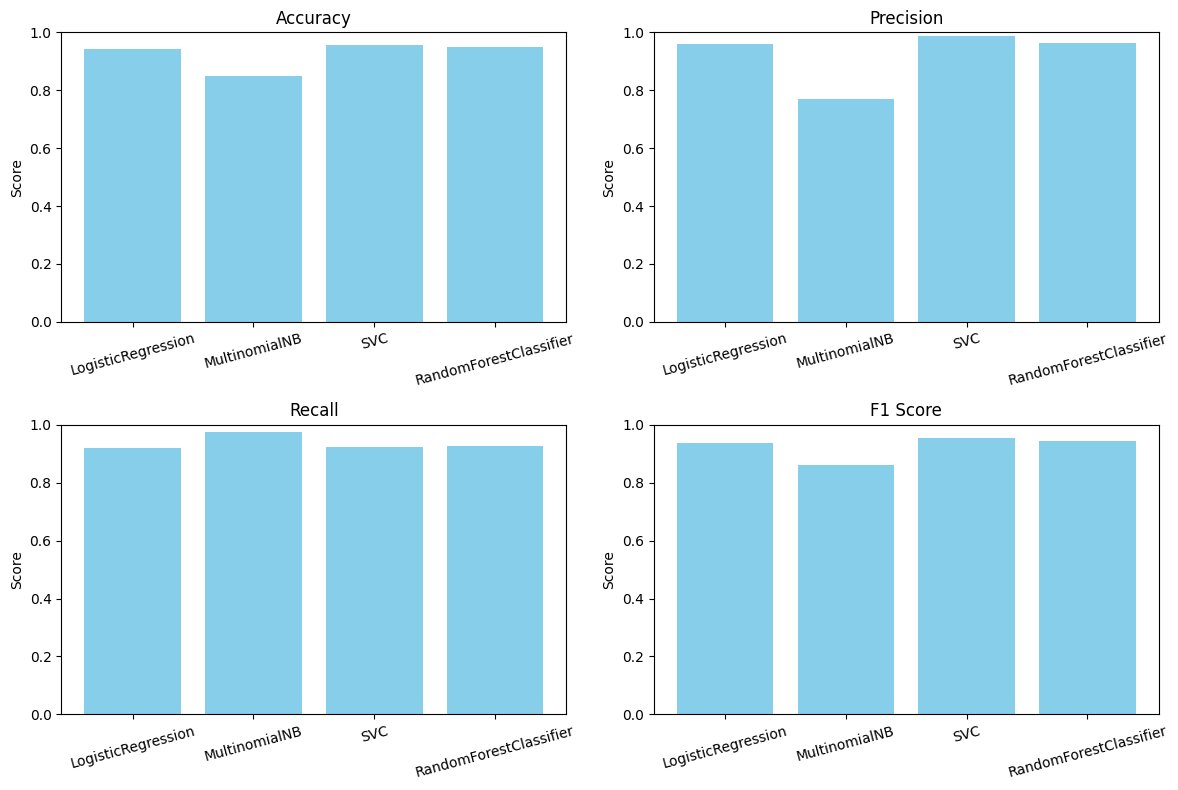

In [ ]:
df_plot = results_df.copy()

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Plot each metric in a separate subplot
for i, metric in enumerate(df_plot.index):
    axes[i].bar(df_plot.columns, df_plot.loc[metric], color='skyblue')
    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Score")
    axes[i].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

## **OBJECTIVE 5**

Use 3-5 trained models for the ensemble approach

For our ensemble approach, let's use logistic regression, SVM, and random forests.

In [58]:
from sklearn.ensemble import VotingClassifier

logreg = LogisticRegression()
svc = SVC(probability=True)
rf = RandomForestClassifier()

# Soft Voting Ensemble
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('svc', svc),
        ('rf', rf)
    ],
    voting='soft'  # Use soft voting
)

voting_clf.fit(X_train_tfidf, y_train)
y_pred = voting_clf.predict(X_test_tfidf)

ensemble_results = {}

ensemble_results['SoftVoting'] = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred)
}

# Update results DataFrame
res = pd.DataFrame(ensemble_results)
dump(voting_clf, "./serialized/EnsembleSoftVoting.pkl")

res.head()



,SoftVoting
Accuracy,0.961059
Precision,0.970000
Recall,0.947883
F1 Score,0.958814


## **OBJECTIVE 6**

Perform inference on sample data with [LIME](https://github.com/marcotcr/lime.git)

In [97]:
# Randomly sample one row from the DataFrame
sample = new_df.sample()
print(f"Original: {sample.values[0]}")

# Extract the text and label as raw values
sample_text = preprocess_text(sample['articles'].values[0], nlp)
sample_text = ' '.join(sample_text)
label = sample['labels'].values[0]

print(sample_text, type(sample_text))
print(label, type(label))

Original: ['Tiniyak ng pamahalaan ng Bahrain na ang mga overseas Filipino workers (OFW) ay protektado sa kanilang bansa. Ang garantiya ng Bahrain ay isiniwalat ni Department of Foreign Affairs (DFA) Secretary Alan Peter Cayetano noong Lunes, ika-14 ng Mayo. Si Sec. Cayetano ay nagtungo sa Bahrain noong ika-13 hanggang ika-14 ng Mayo kung saan nakipagpulong siya kay Bahrain Prime Minister Khalifa Bin Salman Al Khalifa sa Gudaibiya Palace kung saan sinabi umano ni Al Khalifa ang patuloy na pagsuporta sa Pilipinas. Ayon sa ulat ng Eagle News, sinabi umano ng lider ng Bahrain kay Cayetano ang kanilang ginawang mga hakbang upang maprotektahan ang mga karapatan at maitaguyod ang kapakanan ng  mga OFW at ng iba pang mga manggagawa mula sa ibang bansa. Pinuri umano ni Prime Minister Al Khalifa ang 60,000 na OFW sa kanilang bayan at sinabi na handa pa rin silang tumangagp ng mas marami pang mga Pilipinong manggagawa.'
 1 150
 list(['tiyak', 'pamahalaan', 'bahrain', 'overseas', 'filipino', 'work

In [ ]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import numpy as np

from sklearn.pipeline import make_pipeline

model = load('./serialized/LogisticRegression.pkl')  # Load any model you want to interpret

# Wrap vectorizer and model into one pipeline
c = make_pipeline(vectorizer, model)

class_names = ["Real News", "Fake News"] # 0, 1

In [ ]:
explainer = LimeTextExplainer(class_names=class_names)

exp = explainer.explain_instance(sample_text, c.predict_proba, num_features=10)

exp.save_to_file('sample_lime_explanation.html')